<a href="https://colab.research.google.com/github/SNMHZ/DART_ESG_Project/blob/main/BackTest_By_KCGS_Grade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#여기부터 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install PyMySQL

     |████████████████████████████████| 51kB 2.8MB/s 


In [3]:
import pymysql

#여기부터 KCGS 데이터 로드 및 전처리

In [4]:
#2011년도부터 2020년도까지 KCGS ESG DATA 로딩
ESG_DF_DICT={}
for i in range(10):
  ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)]=pd.read_excel('https://github.com/SNMHZ/DART_ESG_Project/raw/main/KCGS_DATA/KCGS_ESG_%d.xlsx'%(i+2011), index_col=0)

In [5]:
#텍스트로 구성된 등급을 숫자로 어떻게 변환 할 것 인가? 에 대한 정보(제 마음대로 정했습니다).
grade_num = {}
grade_num['S']=1
grade_num['A+']=1
grade_num['A']=2
grade_num['B+']=3
grade_num['B+이하']=3
grade_num['B']=4
grade_num['B이하']=5
grade_num['C']=6
grade_num['D']=7

In [6]:
#######################   데이터 전처리   #######################
#기업코드 보정. ex) 5930 -> 'A005930',  298000 -> 'A298000'
#ESG등급 보정.  ex) 'A+' -> 1, A -> 2
#(보정 전 데이터) + (불필요 데이터. ex. 비고 등) 삭제
#################################################################
for i in range(10):
  ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)]=ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)].drop(columns=['비고 (조정시기)']).dropna()
  str_list=[]
  for num in ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)]['기업코드']:
    str_list.append('A%06d'%num)
  ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)]['기업코드_보정']=str_list
  for col in ['ESG등급', '환경', '사회', '지배구조']:
    m_list=[]
    for data in ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)][col]:
      m_list.append(grade_num[data])
    ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)][col+'N']=np.array(m_list, dtype='int64')
  for name in ['기업코드', 'ESG등급', '환경', '사회', '지배구조', '평가년도']:
    del ESG_DF_DICT['KCGS_ESG_%d'%(i+2011)][name]

#보정된 데이터 프레임의 모습

In [7]:
ESG_DF_DICT['KCGS_ESG_2017']

,기업명,기업코드_보정,ESG등급N,환경N,사회N,지배구조N
NO,,,,,,
732,AJ네트웍스,A095570,5,5,5,4
731,AJ렌터카,A068400,5,5,5,6
730,AK홀딩스,A006840,5,5,5,4
729,BGF,A027410,5,5,2,4
728,BNK금융지주,A138930,3,3,2,4
...,...,...,...,...,...,...
5,휴비스,A079980,3,3,2,4
4,휴스틸,A005010,5,5,5,4
3,휴켐스,A069260,3,3,3,4


#여기부터 함수 및 DB 커넥션 설정.

In [8]:
##################데이터 DB에서 가져오기 함수###################
#######input
#stock_list -> 종목 코드 리스트(string)
#start_date -> 쿼리 시작일(당일 포함)
#start_date -> 쿼리 종료일(당일 포함)
#cursor -> pymysql 데이터베이스 커서

#######output
#시계열 주가 정보.
#( col == 종목 코드 ) && ( row == 시계열[start_date:end_date] )

################################################################
def quarry_value(stock_list, start_date, end_date, cursor):
  #stock_list_result 생성. DB관계도 때문에 미리 세팅.
  sql = "SELECT * FROM table_info WHERE"
  for i, stock_code in enumerate(stock_list):
    if i:
      sql+=' or'
    sql+=" Symbol='"+stock_code+"'"
  cursor.execute(sql)
  stock_list_result = pd.DataFrame(cursor.fetchall())

  #관계도 바탕으로 각 주가 쿼리.
  r_df=pd.DataFrame(index=pd.date_range(start_date, end_date), dtype='int64')
  for i in range(len(stock_list_result)):
    print('\rfetching '+stock_list_result.loc[i][0]+' %d/%d'%(i+1, len(stock_list_result)), end='')
    #stock_list_result.loc[i][0] #기업코드 str
    #stock_list_result.loc[i][2] #테이블넘버 int
    #쿼리문 작성
    sql = "SELECT "+stock_list_result.loc[i][0]+" FROM rsp"+str(stock_list_result.loc[i][2])+" WHERE DATE BETWEEN '"+start_date+"' and '"+end_date+"';"
    cursor.execute(sql)
    result = cursor.fetchall()
    r_df[stock_list_result.loc[i][0]]=pd.DataFrame(result, index=pd.date_range(start_date, end_date), dtype='int64')[stock_list_result.loc[i][0]].astype('int64')
  print('\rfetching end.')
  return r_df

In [9]:
##############  기준정보 DB에서 가져오기 함수  #################
#######input
#start_date -> 쿼리 시작일(당일 포함)
#start_date -> 쿼리 종료일(당일 포함)
#cursor -> pymysql 데이터베이스 커서

#######output
#시계열 지수 정보
#( col == kospi, kospi200, kosdaq ) && ( row == 시계열[start_date:end_date] )

################################################################
def quarry_standard(start_date, end_date, cursor):
  #쿼리문 작성
  sql = "SELECT kospi, kospi200, kosdaq FROM standard_table WHERE DATE BETWEEN '"+start_date+"' and '"+end_date+"';"
  cursor.execute(sql)
  result = cursor.fetchall()
  r_df=pd.DataFrame(result, index=pd.date_range(start_date, end_date))
  for col in r_df.columns:
    r_df[col]=r_df[col].astype('float64')
  print('\rfetching end.')
  return r_df

In [10]:
#input  -> 위에서 쿼리한 시계열 주가 정보
#output -> 백테스트 변화율.
def backtest(value_df, seed_money=100000000):
  #지갑가치 조회
  def get_stock_wallet_price(stock_wallet, date):
    stock_wallet_value=0
    for stock_name in stock_wallet.keys():
      stock_wallet_value+=stock_wallet[stock_name]*value_df[stock_name][date]
    return stock_wallet_value

  current_money=seed_money
  screened_stock_count=len(value_df.columns)
  money_per_stock=current_money/screened_stock_count
  rebalance_date=value_df.index[0]

  #사놓을 거 지갑 만들기. (key-value)==(종목코드-구매 개수)
  stock_wallet={}
  for to_buy in value_df.columns:
    stock_wallet[to_buy] = int(money_per_stock//value_df[to_buy][rebalance_date])

  #백테스트 데이터프레임 뼈대 생성
  backtest=pd.DataFrame(index=value_df.index)

  stock_val_list=np.array([], dtype='int64')
  for date in value_df.index:
    stock_val_list = np.append(stock_val_list, get_stock_wallet_price(stock_wallet, date))
  backtest['stock_val']=stock_val_list
  cash=seed_money-get_stock_wallet_price(stock_wallet, rebalance_date)
  backtest['cash']=np.array([cash]*len(value_df), dtype='int64')
  backtest['total']=backtest['stock_val']+backtest['cash']
  backtest['total_change']=backtest['total']/backtest['total'][backtest.index[0]]-1

  return backtest

In [11]:
def visualize(standard_df, std_str, backtest_df_list=[], label_list=[]):
  plt.figure(figsize = (15,8))
  standard_df['total_change'].plot(linestyle='--', label=std_str)
  for i, m_df in enumerate(backtest_df_list):
    label_str=''
    if len(label_list)<=i:
      label_str=str(i)
    else:
      label_str=label_list[i]
    m_df['total_change'].plot(label=label_str)
  plt.plot()
  plt.legend(loc='upper left')
  plt.show()

In [21]:
#제가 개인적으로 설정해두고 이용하는 데이터베이스 서버입니다.

# at = pymysql.connect(
#     user='', 
#     passwd='', 
#     host='', 
#     db='', 
#     charset=''
# )
# m_cursor = at.cursor(pymysql.cursors.DictCursor)

#여기부터 백테스트.



In [13]:
ESG2017=ESG_DF_DICT['KCGS_ESG_2017']

In [14]:
#종합 ESG등급으로 백테스트. A+, A등급만 포함.
ESG2017_value_df = quarry_value(ESG2017.loc[ESG2017['ESG등급N'] <= 2]['기업코드_보정'], '2018-01-01', '2018-12-31', m_cursor)
comp = backtest(ESG2017_value_df, seed_money=1000000000)
comp

fetching end.


,stock_val,cash,total,total_change
2018-01-01,998268027,1731973,1000000000,0.000000
2018-01-02,1004962340,1731973,1006694313,0.006694
2018-01-03,1007913016,1731973,1009644989,0.009645
2018-01-04,1008941576,1731973,1010673549,0.010674
2018-01-05,1019781998,1731973,1021513971,0.021514
...,...,...,...,...
2018-12-27,897060821,1731973,898792794,-0.101207
2018-12-28,901230217,1731973,902962190,-0.097038
2018-12-29,901230217,1731973,902962190,-0.097038
2018-12-30,901230217,1731973,902962190,-0.097038


In [15]:
#환경(E) 등급으로 백테스트. A+, A등급만 포함.
ESG2017_value_df=quarry_value(ESG2017.loc[ESG2017['환경N'] <= 2]['기업코드_보정'], '2018-01-01', '2018-12-31', m_cursor)
envi = backtest(ESG2017_value_df, seed_money=1000000000)
envi

fetching end.


,stock_val,cash,total,total_change
2018-01-01,996882608,3117392,1000000000,0.000000
2018-01-02,1012834499,3117392,1015951891,0.015952
2018-01-03,1025103344,3117392,1028220736,0.028221
2018-01-04,1026348555,3117392,1029465947,0.029466
2018-01-05,1034492055,3117392,1037609447,0.037609
...,...,...,...,...
2018-12-27,938140046,3117392,941257438,-0.058743
2018-12-28,941820509,3117392,944937901,-0.055062
2018-12-29,941820509,3117392,944937901,-0.055062
2018-12-30,941820509,3117392,944937901,-0.055062


In [16]:
#사회(S) 등급으로 백테스트. A+, A등급만 포함.
ESG2017_value_df=quarry_value(ESG2017.loc[ESG2017['사회N'] <= 2]['기업코드_보정'], '2018-01-01', '2018-12-31', m_cursor)
soci = backtest(ESG2017_value_df, seed_money=1000000000)
soci

fetching end.


,stock_val,cash,total,total_change
2018-01-01,995399782,4600218,1000000000,0.000000
2018-01-02,1000969521,4600218,1005569739,0.005570
2018-01-03,1002455755,4600218,1007055973,0.007056
2018-01-04,1001505512,4600218,1006105730,0.006106
2018-01-05,1010969765,4600218,1015569983,0.015570
...,...,...,...,...
2018-12-27,866637692,4600218,871237910,-0.128762
2018-12-28,869730673,4600218,874330891,-0.125669
2018-12-29,869730673,4600218,874330891,-0.125669
2018-12-30,869730673,4600218,874330891,-0.125669


In [17]:
#지배구조(G) 등급으로 백테스트. A+, A등급만 포함.
ESG2017_value_df=quarry_value(ESG2017.loc[ESG2017['지배구조N'] <= 2]['기업코드_보정'], '2018-01-01', '2018-12-31', m_cursor)
gove = backtest(ESG2017_value_df, seed_money=1000000000)
gove

fetching end.


,stock_val,cash,total,total_change
2018-01-01,998518397,1481603,1000000000,0.000000
2018-01-02,999235706,1481603,1000717309,0.000717
2018-01-03,998504232,1481603,999985835,-0.000014
2018-01-04,994589229,1481603,996070832,-0.003929
2018-01-05,1012701796,1481603,1014183399,0.014183
...,...,...,...,...
2018-12-27,839254903,1481603,840736506,-0.159263
2018-12-28,844330247,1481603,845811850,-0.154188
2018-12-29,844330247,1481603,845811850,-0.154188
2018-12-30,844330247,1481603,845811850,-0.154188


In [18]:
#비교군 데이터 추출. kospi지수로 테스트.
std_df=quarry_standard('2018-01-01', '2018-12-31', m_cursor)
std_df['total_change']=std_df['kospi200']/std_df['kospi200'][std_df.index[0]]-1
std_df

fetching end.


,kospi,kospi200,kosdaq,total_change
2018-01-01,2467.49,324.74,798.42,0.000000
2018-01-02,2479.65,326.00,812.45,0.003880
2018-01-03,2486.35,327.13,822.31,0.007360
2018-01-04,2466.46,324.58,808.01,-0.000493
2018-01-05,2497.52,328.97,828.03,0.013026
...,...,...,...,...
2018-12-27,2028.44,260.57,667.88,-0.197604
2018-12-28,2041.04,261.98,675.65,-0.193262
2018-12-29,2041.04,261.98,675.65,-0.193262
2018-12-30,2041.04,261.98,675.65,-0.193262


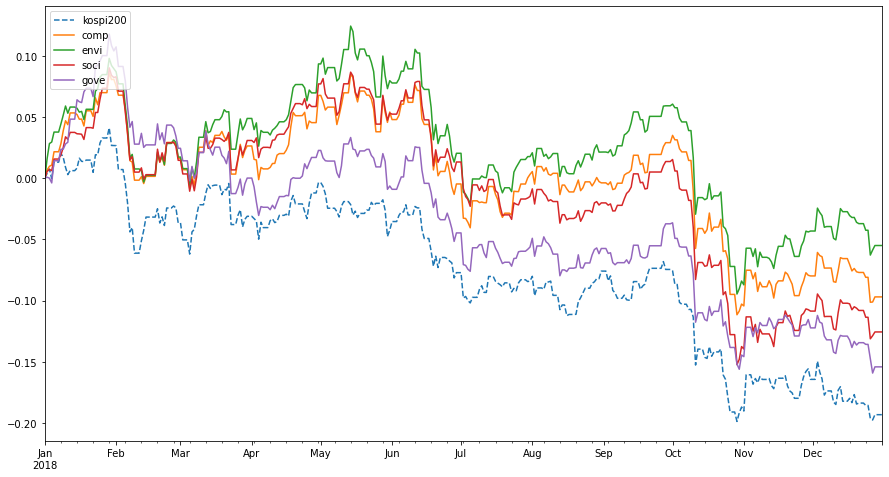

In [19]:
#비교군 포함.
visualize(std_df, 'kospi200', [comp, envi, soci, gove], ['comp', 'envi', 'soci', 'gove'])